# CLASE 19 - Algortimos de clasificación
### Coderhouse - Data Science
Profe Jorge Ruiz

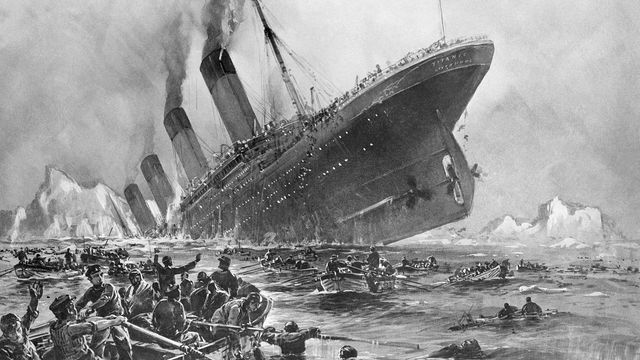

Fue un transatlántico británico, el mayor barco de pasajeros del mundo al finalizar su construcción, que se hundió durante la noche del 14 y la madrugada del 15 de abril de 1912 durante su viaje inaugural desde Southampton a Nueva York. En el hundimiento del Titanic murieron 1496 personas de las 2208 que iban a bordo, lo que convierte a esta catástrofe en uno de los mayores naufragios de la historia ocurridos en tiempos de paz.

Fuente: Wikipedia



La pregunta que se busca responder es:

**Sabiendo los datos de cada pasajero, ¿se puede predecir si sobrevivió o no?**



# No importa si Jack entraba en la tabla...




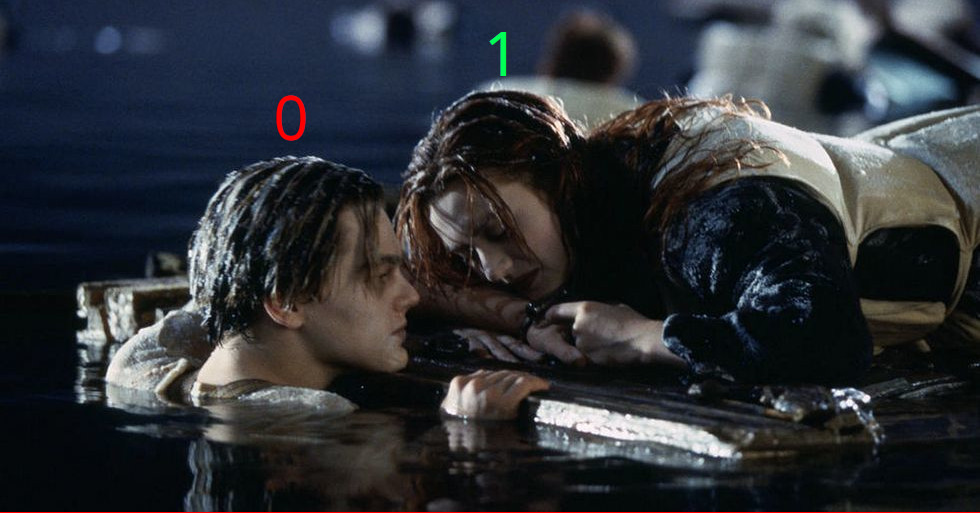

Preparemos la data antes de aplicar ML



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns


from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer

In [ ]:
train_df = pd.read_csv(
    "https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/titanic/train.csv")

test_df = pd.read_csv(
    "https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/titanic/test.csv")

print(f"TOTAL DATA AMOUNT: {len(train_df)+len(test_df)}")

In [ ]:
# Que dimensiones tienen los datos

print("Training set shape: ", train_df.shape)
print("Test set shape: ", test_df.shape)

In [ ]:
print(f">> COLUMNAS DE: TRAINING {train_df.columns}")
print(f">> COLUMNAS DE: TESTING {test_df.columns}")

In [ ]:
# Por ejemplo, veamos que hay en "Embarked"
# set(train_df["Embarked"].values)

train_df["Embarked"].unique() # otra forma alternativa

Valores otorgados por el dataset

In [ ]:
cross_table = pd.crosstab(
    train_df["Survived"],
    [train_df["Sex"], train_df["Embarked"]],
    margins=True, margins_name="Total"
)

cross_table

In [ ]:
# Create the crosstab
multiple_data_info = pd.crosstab(
    train_df["Survived"],
    [train_df["Sex"], train_df["Embarked"]],
    margins=True, margins_name="Total",
    normalize='all'
)

multiple_data_info

# Datos
Veamos el detalle de cada feature:

**Survived**: 0 = No sobrevivió, 1 = sobrevivió (lo que vamos a querer predecir)

**Pclass**: Clase, donde 1 = Primera clase, 2 = Segunda clase, 3 = Tercera clase.

**Sex**: Masculino o Femenino

**Age**: Edad en años, en fracción si es menor de 1

**SibSp**: Número de hermanos o cónyuges a bordo del titanic

**Parch**: Número de padres o hijos a bordo del titanic

**Ticket**: Número de ticket de pasajero

**Fare**: Tarifa de pasajero

**Cabin**: Número de cabina

**Embarked**: Punto de embarque, donde C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
train_df.info(verbose=True,show_counts=True)

In [ ]:
train_df.describe().transpose()

In [ ]:
# train_df.describe(include='category')
# no tenemos variables que previamente reconozca como categóricas, eso hay que solucionarlo

In [ ]:
train_df['Sex'] = train_df['Sex'].astype('category')
train_df['Pclass'] = train_df['Pclass'].astype('category')

train_df.describe(include='category').transpose()

In [ ]:
# veamos la columna Survived que es nuestro target

survived_counts = train_df['Survived'].value_counts()

fig, ax = plt.subplots()

# Genera el gráfico circular
ax.pie(survived_counts, labels=survived_counts.index,
       autopct='%1.1f%%', startangle=90)

ax.set_title('Porcentaje de clases')

In [ ]:
# primer análisis, estámos ignorando las edades faltantes

women = train_df[train_df['Sex'] == 'female']
men = train_df[train_df['Sex'] == 'male']

women = women.dropna(subset="Age")
men = men.dropna(subset="Age")
print("Cantidad de mujeres:", len(women))
print("Cantidad de hombres", len(men))

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.histplot(data=women, x='Age', bins=np.arange(0, 80, 5), hue='Survived',
             multiple='stack', palette={0: 'red', 1: 'green'}, kde=False, ax=axes[0])
axes[0].set_title('Mujeres')

sns.histplot(data=men, x='Age', bins=np.arange(0, 80, 5), hue='Survived',
             multiple='stack', palette={0: 'red', 1: 'green'}, kde=False, ax=axes[1])
axes[1].set_title('Hombres')
fig.set_tight_layout(tight=True)

Parece que hay cierta verdad en eso de "Mujeres y niños primero", pero tambien seamos más realistas...

In [ ]:
sns.barplot(x='Pclass', y='Survived', data=train_df, errorbar=None)

In [ ]:
figure = plt.figure(figsize=(25, 7))
sns.histplot(data=train_df, bins=50, x='Fare', hue='Survived',
             multiple='stack', palette={0: 'red', 1: 'green'}, kde=False)
ax.legend()

Es un análisis muy básico, pero concuerda  con lo que sabemos y/o suponemos. En la primera aproximación podemos usar solo el sexo, la edad y la clase, así que descartemos el resto.

In [ ]:
selected_train = train_df[['Age', 'Pclass', 'Sex', 'Survived']]
selected_train.head()

Transformemos el sexo en categórica

In [ ]:
selected_train['Sex'] = selected_train['Sex'].map({'male': 0, 'female': 1})
selected_train.head()

In [ ]:
selected_test = test_df[['Age', 'Pclass', 'Sex']]
selected_test['Sex'] = selected_test['Sex'].map({'male': 0, 'female': 1})
selected_test = selected_test.dropna(subset="Age")
selected_test

Veamos que datos faltan:

In [ ]:
# Hay muchos datos faltantes en edad, qué podemos hacer?
# La función pandas.isnull/isna detecta valores perdidos

selected_train.isnull().sum().sort_values(ascending=False)

Parece que nos faltan muchos datos en "Edad", separemos las etiquetas y despues vemos que hacemos con eso.

In [ ]:
X_train_w_null = selected_train.drop('Survived', axis=1)
# ya las dejamos listas para entrenar
y_train = selected_train['Survived'].to_numpy()

Podemos eliminar estos datos faltante, en este caso vamos reemplazar los valores faltantes de edad con la mediana.

In [ ]:

# Crear un objeto SimpleImputer con la estrategia de imputación 'median'
imputer = SimpleImputer(strategy='median')

# Seleccionar las columnas con valores faltantes
cols_with_missing_values = ["Age"]

# Imputar los valores faltantes con la mediana en las columnas seleccionadas
X_train_w_null[cols_with_missing_values] = imputer.fit_transform(
    X_train_w_null[cols_with_missing_values])

In [ ]:
X_train_w_null.isnull().sum().sort_values(ascending=False)
# podemos observar que datos faltantes en Age es igual a 0. Funcionó!!!

In [ ]:
X_train = X_train_w_null
X_train

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

---


## Algoritmos de clasificacion binaria -> `0 - 1`

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
# PARAMETROS DE CLASIFICACION BINARIA A USAR

models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=1),
    'KNeighborsClassifier': KNeighborsClassifier(algorithm='auto'),
    'SVC': SVC(probability=True),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

models_params = {
    "RandomForestClassifier": {
        'n_estimators': [50, 100, 200],
        'max_depth': None,
        'min_samples_split': [2, 5]
    },
    "KNeighborsClassifier": {
        'n_neighbors': [3, 5, 10, 15],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    "SVC": {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['linear', 'poly', 'rbf'],
        'probability': True
    },
    "LogisticRegression": {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2', 'elastic_net'],
        'solver': ['lbfgs', 'lbfgs'],
        'max_iter': [100, 1000]
    }
}

In [ ]:
pipelines = {
    name: Pipeline([
        ('scaler', StandardScaler()),  # Scaling step
        ('model', model)
    ])
    for name, model in models.items()
}

In [ ]:
# Evaluate models using cross-validation
results = {}
for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_train, y_train,
                             cv=5, scoring='accuracy')
    results[name] = {
        "Mean Accuracy": np.mean(scores),
        "Std Deviation": np.std(scores)
    }

# Test the models on the test set
test_accuracies = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    test_accuracies[name] = accuracy_score(y_test, pipeline.predict(X_test))

# Combine results
benchmark_results = pd.DataFrame(results).transpose()
benchmark_results["Test Accuracy"] = test_accuracies.values()

print("Benchmark Results:")
benchmark_results

In [ ]:
from sklearn.model_selection import GridSearchCV


models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=1),
    'KNeighborsClassifier': KNeighborsClassifier(algorithm='auto'),
    'SVC': SVC(probability=True),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

param_grids = {
    "RandomForestClassifier": {
        "model__n_estimators": [50, 100, 200],
        "model__max_depth": [None, 10, 20],
    },
    "KNeighborsClassifier": {
        "model__n_neighbors": [3, 5, 7],
        "model__weights": ["uniform", "distance"],
    },
    "SVC": {
        "model__C": [0.1, 1, 10],
        "model__kernel": ["linear", "rbf"],
    },
    "LogisticRegression": {
        "model__C": [0.1, 1, 10],
        "model__solver": ["liblinear", "lbfgs"],
    }
}


pipelines = {
    name: Pipeline([
        ('scaler', StandardScaler()),  # Scaling step
        ('model', model)
    ])
    for name, model in models.items()
}

results = {}
test_accuracies = {}
best_params = {}


for name, pipeline in pipelines.items():
    print(f"Optimizing {name}...")

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    best_params[name] = grid_search.best_params_
    results[name] = {
        "Mean Accuracy": grid_search.best_score_,
        "Std Deviation": np.std(grid_search.cv_results_['mean_test_score'])
    }

    test_accuracies[name] = accuracy_score(
        y_test, grid_search.best_estimator_.predict(X_test))

benchmark_results = pd.DataFrame(results).T
benchmark_results["Test Accuracy"] = test_accuracies.values()
benchmark_results["Best Params"] = best_params.values()

print("\n>>> Benchmark Results with Best Parameters:")
benchmark_results

In [ ]:
benchmark_results["Best Params"].values

---

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, n_estimators=200)

clf.fit(X_train, y_train)

In [ ]:
y_pred_train = clf.predict(X_train)

In [ ]:
# En RF, puedes obtener la importancia de las variables utilizando el atributo feature_importances_ del clasificador entrenado.
# nos devuelve la importancia la de las variables  y se basa en la medida de impureza utilizada durante la construcción de los arboles, en este caso gini.

importances = clf.feature_importances_

# Obtener los nombres de las variables
feature_names = X_train.columns

# Crear un DataFrame con las importancias de las variables
importance_df = pd.DataFrame(
    {'Variable': feature_names, 'Importance': importances})

# Ordenar el DataFrame por importancia descendente
importance_df = importance_df.sort_values('Importance', ascending=False)


importance_df

# se recomienda revisar https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [ ]:
from sklearn.metrics import classification_report

# resultados en entrenamiento
print(classification_report(y_true=y_train, y_pred=y_pred_train))

In [ ]:
# resultados en testeo

y_pred_test = clf.predict(selected_test)
y_pred_test

##Guardar un modelo para usarlo a futuro.

In [ ]:
import pickle

# Supongamos que tienes un modelo entrenado llamado "clf"
modelo = clf

# Guardamos el modelo en un archivo utilizando pickle
with open('modelo_clf.pkl', 'wb') as archivo:
    pickle.dump(modelo, archivo)

In [ ]:
# ahora veamos como usarlo a futuro

# Cargamos el modelo
with open('modelo_clf.pkl', 'rb') as archivo:
    modelo_cargado = pickle.load(archivo)

# Utilizar el modelo cargado para hacer predicciones, por ejemplo:
predicciones = modelo_cargado.predict(selected_test)
predicciones

In [ ]:
# Vamos a realizar una predicción manual teniendo en cuenta el orden de entrenamiento de las características:
# Edad (Age), Clase de boleto (Pclass) y Género (Sex), donde 0 representa hombre y 1 representa mujer.

clf.predict(np.array([25, 2, 0]).reshape(1, -1))

# otra forma de hacerlo clf.predict([[30, 3, 0]])

# Es su turno de poder practicar:




# Lo mínimo
Prueben no menos de dos algoritmos de clasificación que hayamos visto durante el curso para tratar de predecir si un pasajero sobrevive o no. Recuerden que sus features estan dentro de X_train y su target es y_train.


# Si queda tiempo y sino para sus casas (*)
Fíjense que no usamos el conjunto de test, se puede incorporar para mejorar la aproximación de las edades faltantes. También pueden incorporar nuevos features (por ejemplo no usamos la tarifa o incluso el puerto de embarque si tiene una relación) o crear otros nuevos. También se podria mejorar la aproximación de las edades discretizando o incluso tener en cuenta si tiene hijos o hermanos, etc.
